# Advanced Modeling of Groundwater Flow (GW3099)
![header](../img/header.jpg)

# Exercise 1: Flopy, MODFLOW, and MODPATH
The purpose of this exercise is to use Flopy to simulate example problem 1 using MODFLOW-2005, MODPATH, and MT3D.

## Part I. Setup Notebook

In [1]:
%matplotlib inline
from __future__ import print_function
import sys
import os
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

if '..' not in sys.path:
    sys.path.append('..')
import config

print(sys.version)
print('python executable: {}'.format(sys.executable))
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

Executable file found: Z:\langevin\training\AdvancedModeling2018\gw3099_classrepo.git\exercises\bin\win64\mf2005.exe
Executable file found: Z:\langevin\training\AdvancedModeling2018\gw3099_classrepo.git\exercises\bin\win64\mp7.exe
Executable file found: Z:\langevin\training\AdvancedModeling2018\gw3099_classrepo.git\exercises\bin\win64\mt3dms.exe
Executable file could not be found: Z:\langevin\training\AdvancedModeling2018\gw3099_classrepo.git\exercises\bin\win64\mf6.exe
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
python executable: C:\Users\langevin\Anaconda3\python.exe
numpy version: 1.14.1
matplotlib version: 2.1.2
flopy version: 3.2.9


## Part II. Create, Run, and Post-Process MODFLOW-2005 Model

In [2]:
# model info
model_name = 'ex01'
model_ws = './ex01-completed'

# grid properties
nlay = 3
nrow = 21
ncol = 20
delr = 500.
delc = 500.
top = 400.
botm = [220., 200., 0.]

# hydraulic properties
hk0 = 50.
vk0 = 10.
hk1 = 0.01
vk1 = 0.01
hk2 = 200.
vk2 = 20

# boundary conditions
welspd = [3 - 1, 11 - 1, 10 - 1, -1.5e5]
rech = 0.005
rivspd = [[0, ir, ncol-1, 320., 1.e5, 318.] for ir in range(nrow)]

In [3]:
m = flopy.modflow.Modflow(modelname=model_name, model_ws=model_ws, exe_name=config.mfexe)
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, delr=delr, delc=delc, top=top, botm=botm)
bas = flopy.modflow.ModflowBas(m)
lpf = flopy.modflow.ModflowLpf(m, hk=[hk0, hk1, hk2], vka=[vk0, vk1, vk2])
wel = flopy.modflow.ModflowWel(m, stress_period_data=welspd)
rch = flopy.modflow.ModflowRch(m, rech=rech)
riv = flopy.modflow.ModflowRiv(m, stress_period_data=rivspd)
pcg = flopy.modflow.ModflowPcg(m)
lmt = flopy.modflow.ModflowLmt(m)
oc  = flopy.modflow.ModflowOc(m, stress_period_data={(0, 0): ['SAVE HEAD', 'SAVE BUDGET']})
oc.reset_budgetunit()
m.write_input()
m.run_model()

FloPy is using the following  executable to run the model: Z:\langevin\training\AdvancedModeling2018\gw3099_classrepo.git\exercises\bin\win64\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ex01.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/15 11:38:25

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/10/15 11:38:25
 Elapsed run time:  0.028 Seconds

  Normal termination of simulation


(True, [])

In [4]:
# load the heads and budget files
fname = os.path.join(model_ws, model_name + '.hds')
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()

fname = os.path.join(model_ws, model_name + '.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
fff = cbb.get_data(text='FLOW FRONT FACE')[0]

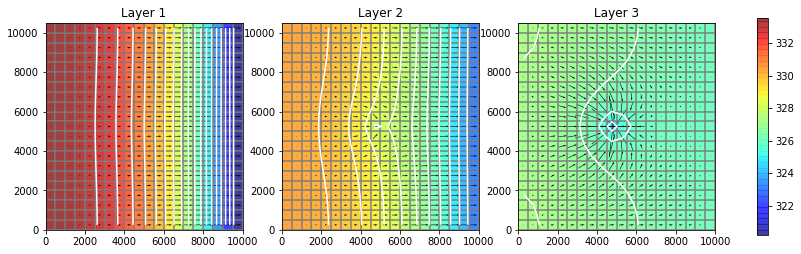

In [5]:
# plot the results for each layer
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
vmin = head.min()
vmax = head.max()
levels = np.linspace(vmin, vmax, 20)

for ilay in range(nlay):
    ax = axes[ilay]
    #ax = fig.add_subplot(1, nlay, ilay + 1, aspect='equal')
    ax.set_title('Layer {}'.format(ilay + 1))
    ax.set_aspect('equal')
    modelmap = flopy.plot.ModelMap(model=m, layer=ilay, ax=ax)
    quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5, 
                                   vmin=vmin, vmax=vmax, cmap='jet')
    linecollection = modelmap.plot_grid()
    contour_set = modelmap.contour_array(head, levels=levels, colors='white')
    quiver = modelmap.plot_discharge(frf, fff, head=head)
cb = fig.colorbar(quadmesh, ax=axes, shrink=0.5)

## Part II. Create and Run MODPATH-7 Model

In [6]:
# particles
partlocs = [(0, i, 0) for i in range(nrow)]
particledata = flopy.modpath.ParticleData(partlocs, structured=True)
pg = flopy.modpath.ParticleGroup(particledata=particledata)

In [8]:
mp = flopy.modpath.Modpath7(modelname='ex01_mp', model_ws=model_ws, flowmodel=m, exe_name=config.mpexe)
mpbas = flopy.modpath.Modpath7Bas(mp)
mpsim = flopy.modpath.Modpath7Sim(mp, particlegroups=pg)
mp.write_input()
mp.run_model()

FloPy is using the following  executable to run the model: Z:\langevin\training\AdvancedModeling2018\gw3099_classrepo.git\exercises\bin\win64\mp7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         2 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        19 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                

(True, [])

In [9]:
# load the pathline results
fname = os.path.join(model_ws, 'ex01_mp.mppth')
p = flopy.utils.PathlineFile(fname).get_alldata()

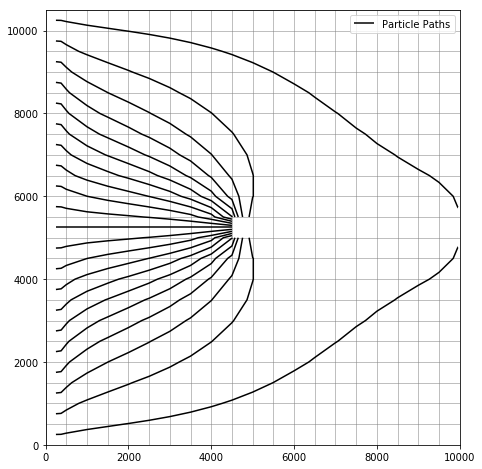

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
mm = flopy.plot.ModelMap(model=m)
mm.plot_grid(lw=0.5)
mm.plot_pathline(p, layer='all', colors='k', label='Particle Paths')
mm.ax.legend();

## Part III. Create and Run MT3D Model

In [11]:
# transport boundary conditions
icbund = np.ones((nlay, nrow, ncol), dtype=np.int)
icbund[0, int(nrow / 2), 0] = -1
sconc = np.zeros((nlay, nrow, ncol), dtype=np.float32)
sconc[0, int(nrow / 2), 0] = 100

# observations
rhalf = int(nrow / 2)
chalf = int(ncol / 2)
obs = [(il, rhalf, chalf) for il in range(nlay)]

In [12]:
modelname = 'ex01_mt3d'
mt = flopy.mt3d.Mt3dms(modelname=modelname, model_ws=model_ws, modflowmodel=m, exe_name=config.mtexe)
btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, sconc=sconc, perlen=100000., nprs=-1, obs=obs)
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(mt, al=10.)
ssm = flopy.mt3d.Mt3dSsm(mt)
gcg = flopy.mt3d.Mt3dGcg(mt)
mt.write_input()
mt.run_model(silent=False, normal_msg='Program completed.')

found 'rch' in modflow model, resetting crch to 0.0
FloPy is using the following  executable to run the model: Z:\langevin\training\AdvancedModeling2018\gw3099_classrepo.git\exercises\bin\win64\mt3dms.exe
MT3DMS - Modular 3-D Multi-Species Transport Model [Version 5.30]
Developed at University of Alabama for U.S. Department of Defense

Using NAME File: ex01_mt3d.nam                                     

STRESS PERIOD NO.    1

TIME STEP NO.    1
FROM TIME =   0.0000     TO   0.10000E+06

Transport Step:    1   Step Size:   374.1     Total Elapsed Time:   374.07    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1766      [K,I,J]    2   11    1
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2594E-06  [K,I,J]    2   11    2
Transport Step:    2   Step Size:   374.1     Total Elapsed Time:   748.14    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1430      [K,I,J]    2   11    1
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4424E-06  [K,I,J]    2   11    2
Transport Step:    3   Step Size:

Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5775E-05  [K,I,J]    3   11    9
Transport Step:   69   Step Size:   374.1     Total Elapsed Time:   25811.    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3573E-02  [K,I,J]    3   11    1
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5781E-05  [K,I,J]    3   11    9
Transport Step:   70   Step Size:   374.1     Total Elapsed Time:   26185.    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3480E-02  [K,I,J]    3   11    1
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5781E-05  [K,I,J]    3   11    9
Transport Step:   71   Step Size:   374.1     Total Elapsed Time:   26559.    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3389E-02  [K,I,J]    3   11    1
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5775E-05  [K,I,J]    3   11    9
Transport Step:   72   Step Size:   374.1     Total Elapsed Time:   26933.    
Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3301E-02  [K,I,J]    3   11    1
Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5764E-

(True, [])

In [13]:
# load the concentrations
fname = os.path.join(model_ws, 'MT3D001.UCN')
cobj = flopy.utils.UcnFile(fname)
conc = cobj.get_data()

# load observations
fname = os.path.join(model_ws, 'MT3D001.OBS')
cobs = flopy.mt3d.Mt3dms.load_obs(fname)

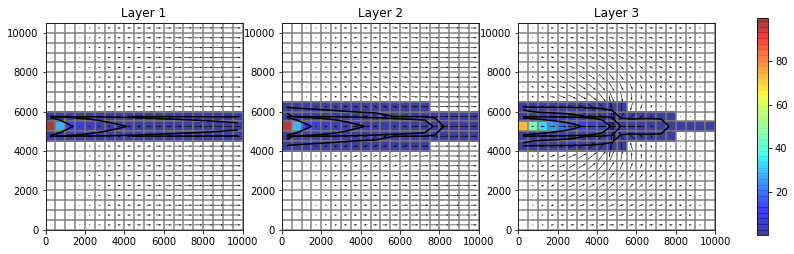

In [14]:
# plot the results for each layer
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
a = conc
a = np.ma.masked_less(a, 1.e-4)
vmin = a.min()
vmax = a.max()
levels = [0.01, .1, 1, 10., 100.]

for ilay in range(nlay):
    ax = axes[ilay]
    ax.set_title('Layer {}'.format(ilay + 1))
    ax.set_aspect('equal')
    modelmap = flopy.plot.ModelMap(model=m, layer=ilay, ax=ax)
    quadmesh = modelmap.plot_array(a, masked_values=[999.], alpha=0.5, 
                                   vmin=vmin, vmax=vmax, cmap='jet')
    linecollection = modelmap.plot_grid()
    contour_set = modelmap.contour_array(a, levels=levels, colors='k')
    quiver = modelmap.plot_discharge(frf, fff, head=head)
cb = fig.colorbar(quadmesh, ax=axes, shrink=0.5)

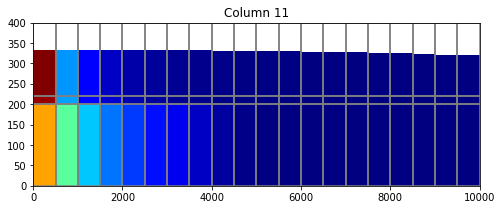

In [15]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.ModelCrossSection(model=m, line={'row': rhalf})
linecollection = modelxsect.plot_grid()
modelxsect.plot_array(a, head=head, cmap='jet')
t = ax.set_title('Column {}'.format(rhalf + 1))

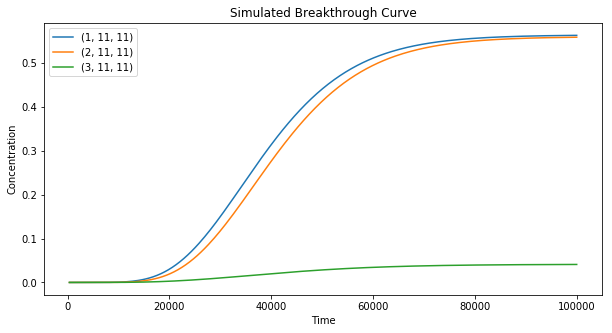

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
for name in cobs.dtype.names:
    if name.startswith('('):
        ax.plot(cobs['time'], cobs[name], label=name)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
ax.set_title('Simulated Breakthrough Curve');